In [1]:
import segmentation_models as sm
from sklearn.model_selection import train_test_split

from brainseg.generator import TrainGenerator, TestGenerator
from brainseg.loader import Loader
from brainseg.utils import load_data, show_batch_multires
from brainseg.image_provider import MultiResImageHandler
from brainseg.provider import provider
from brainseg.streamlit.manager import list_all

import matplotlib.pyplot as plt
import numpy as np
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
from tensorflow.keras.optimizers import Adam
from skimage.transform import resize
from brainseg.utils import to_color, rgb_to_multi

sm.set_framework("tf.keras")

2022-07-20 15:41:13.563155: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nathan/sandbox/elastix/elastix-5.0.1-linux/lib
2022-07-20 15:41:13.563196: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Segmentation Models: using `keras` framework.


In [2]:
from brainseg.models.multires_unet import multires_unet

In [3]:
model = multires_unet(n_res=3, n_classes=1, im_sz=224, n_channels=3,
                      n_filters_start=32, growth_factor=1.2, upconv=True)
model.compile(
    Adam(learning_rate=1e-4),
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)

2022-07-18 14:02:05.901763: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/nathan/.cache/pypoetry/virtualenvs/brainseg-XuOkmMtq-py3.8/lib/python3.8/site-packages/cv2/../../lib64::/home/nathan/sandbox/elastix/elastix-5.0.1-linux/lib
2022-07-18 14:02:05.901791: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-18 14:02:05.901812: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nathan-SBRI): /proc/driver/nvidia/version does not exist


In [4]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Rot90([0, 1, 2, 3]),
])

In [5]:
areas = ["putamen", "whitematter", "claustrum"]
colors = to_color(areas)

In [6]:
sh = MultiResImageHandler(names=["image_x8.png", "image_x32.png"])
provider.register(sh)

In [7]:
def preprocess_augment(x, y):
    xa, xb, xc = x
    xa = np.asarray(xa)
    xb = np.asarray(xb)
    xc = np.asarray(xc)
    y = np.asarray(y)

    y = rgb_to_multi(y, colors)

    
    seg = SegmentationMapsOnImage(y, shape=y.shape)
    current_seq = seq.to_deterministic()
    
    xa, y = current_seq(image=xa, segmentation_maps=seg)
    xb = current_seq(image=xb)
    xc = current_seq(image=xc)
    
    xa = xa / 255.
    xb = xb / 255.
    xc = xc / 255.
    y = y.arr
    
    y = y.astype(np.float64)
    return [xa, xb, xc], y

In [8]:
def preprocess(x, y):
    xa, xb, xc = x
    xa = np.asarray(xa)
    xb = np.asarray(xb)
    xc = np.asarray(xc)
    xa = xa / 255.
    xb = xb / 255.
    xc = xc / 255.
    y = np.asarray(y) / 255.
    y = y.astype(np.float64)
    return [xa, xb, xc], y

In [9]:
dataset = list_all("/media/nathan/LaCie/Data/multi_trires_x8x32x128_224/", min_threshold=10, prefix=sh.name)

In [10]:
len(dataset)

1693

In [11]:
s = list([x[1]["data_name"][:14] for x in dataset])
from collections import Counter
Counter(s)

Counter({'M148 LHRH276.c': 236,
         'M148 LHRH266.c': 233,
         'M148 LHRH244.c': 234,
         'M148 LHRH272.c': 225,
         'M148 LHRH278.c': 235,
         'M148 LHRH280.c': 229,
         'M148 LHRH236.c': 246,
         'M148 LHRH264.c': 55})

In [12]:
print(len(dataset))

1693


In [13]:
train_dataset, test_dataset = train_test_split(dataset, random_state=0)

In [14]:
len(train_dataset)

1269

In [15]:
train_gen = TrainGenerator(Loader(train_dataset), batch_size=4, preprocess=preprocess_augment)
test_gen = TestGenerator(Loader(test_dataset), batch_size=4, preprocess=preprocess)

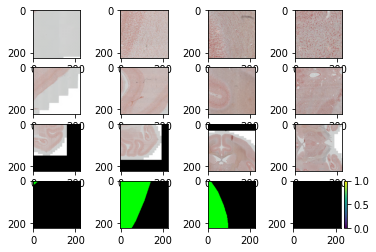

In [16]:
show_batch_multires(train_gen[0])

In [17]:
model = multires_unet(n_res=2, n_classes=1, im_sz=224, n_channels=3, n_filters_start=32, growth_factor=1.2, upconv=True)
model.compile(
    Adam(learning_rate=1e-4),
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)

In [18]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                          

                                                                                                  
 conv2d_168 (Conv2D)            (None, 224, 224, 32  9248        ['leaky_re_lu_167[0][0]']        
                                )                                                                 
                                                                                                  
 conv2d_112 (Conv2D)            (None, 224, 224, 32  9248        ['leaky_re_lu_111[0][0]']        
                                )                                                                 
                                                                                                  
 conv2d_140 (Conv2D)            (None, 224, 224, 32  9248        ['leaky_re_lu_139[0][0]']        
                                )                                                                 
                                                                                                  
 batch_nor

                                )                                                                 
                                                                                                  
 leaky_re_lu_112 (LeakyReLU)    (None, 112, 112, 38  0           ['batch_normalization_221[0][0]']
                                )                                                                 
                                                                                                  
 leaky_re_lu_140 (LeakyReLU)    (None, 112, 112, 38  0           ['batch_normalization_276[0][0]']
                                )                                                                 
                                                                                                  
 leaky_re_lu_169 (LeakyReLU)    (None, 112, 112, 38  0           ['leaky_re_lu_168[0][0]']        
                                )                                                                 
          

 add_44 (Add)                   (None, 112, 112, 38  0           ['batch_normalization_225[0][0]',
                                )                                 'batch_normalization_223[0][0]']
                                                                                                  
 add_55 (Add)                   (None, 112, 112, 38  0           ['batch_normalization_280[0][0]',
                                )                                 'batch_normalization_278[0][0]']
                                                                                                  
 leaky_re_lu_171 (LeakyReLU)    (None, 112, 112, 38  0           ['add_66[0][0]']                 
                                )                                                                 
                                                                                                  
 leaky_re_lu_115 (LeakyReLU)    (None, 112, 112, 38  0           ['add_44[0][0]']                 
          

                                                                                                  
 add_56 (Add)                   (None, 112, 112, 38  0           ['batch_normalization_284[0][0]',
                                )                                 'batch_normalization_282[0][0]']
                                                                                                  
 max_pooling2d_26 (MaxPooling2D  (None, 56, 56, 38)  0           ['add_67[0][0]']                 
 )                                                                                                
                                                                                                  
 max_pooling2d_16 (MaxPooling2D  (None, 56, 56, 38)  0           ['add_45[0][0]']                 
 )                                                                                                
                                                                                                  
 max_pooli

 leaky_re_lu_147 (LeakyReLU)    (None, 56, 56, 46)   0           ['batch_normalization_289[0][0]']
                                                                                                  
 conv2d_176 (Conv2D)            (None, 56, 56, 46)   19090       ['leaky_re_lu_175[0][0]']        
                                                                                                  
 conv2d_120 (Conv2D)            (None, 56, 56, 46)   19090       ['leaky_re_lu_119[0][0]']        
                                                                                                  
 conv2d_148 (Conv2D)            (None, 56, 56, 46)   19090       ['leaky_re_lu_147[0][0]']        
                                                                                                  
 batch_normalization_345 (Batch  (None, 56, 56, 46)  184         ['conv2d_176[0][0]']             
 Normalization)                                                                                   
          

 batch_normalization_239 (Batch  (None, 56, 56, 46)  184         ['conv2d_122[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_237 (Batch  (None, 56, 56, 46)  184         ['add_46[0][0]']                 
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_294 (Batch  (None, 56, 56, 46)  184         ['conv2d_150[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_292 (Batch  (None, 56, 56, 46)  184         ['add_57[0][0]']                 
 Normaliza

 conv2d_124 (Conv2D)            (None, 28, 28, 55)   27280       ['batch_normalization_242[0][0]']
                                                                                                  
 conv2d_152 (Conv2D)            (None, 28, 28, 55)   27280       ['batch_normalization_297[0][0]']
                                                                                                  
 batch_normalization_354 (Batch  (None, 28, 28, 55)  220         ['conv2d_180[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_244 (Batch  (None, 28, 28, 55)  220         ['conv2d_124[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_nor

                                                                                                  
 leaky_re_lu_126 (LeakyReLU)    (None, 28, 28, 55)   0           ['batch_normalization_248[0][0]']
                                                                                                  
 leaky_re_lu_154 (LeakyReLU)    (None, 28, 28, 55)   0           ['batch_normalization_303[0][0]']
                                                                                                  
 conv2d_183 (Conv2D)            (None, 28, 28, 55)   27280       ['leaky_re_lu_182[0][0]']        
                                                                                                  
 conv2d_127 (Conv2D)            (None, 28, 28, 55)   27280       ['leaky_re_lu_126[0][0]']        
                                                                                                  
 conv2d_155 (Conv2D)            (None, 28, 28, 55)   27280       ['leaky_re_lu_154[0][0]']        
          

 leaky_re_lu_184 (LeakyReLU)    (None, 14, 14, 66)   0           ['leaky_re_lu_183[0][0]']        
                                                                                                  
 leaky_re_lu_128 (LeakyReLU)    (None, 14, 14, 66)   0           ['leaky_re_lu_127[0][0]']        
                                                                                                  
 leaky_re_lu_156 (LeakyReLU)    (None, 14, 14, 66)   0           ['leaky_re_lu_155[0][0]']        
                                                                                                  
 batch_normalization_362 (Batch  (None, 14, 14, 66)  264         ['leaky_re_lu_184[0][0]']        
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_252 (Batch  (None, 14, 14, 66)  264         ['leaky_re_lu_128[0][0]']        
 Normaliza

                                                                                                  
 conv2d_187 (Conv2D)            (None, 14, 14, 66)   39270       ['batch_normalization_366[0][0]']
                                                                                                  
 conv2d_131 (Conv2D)            (None, 14, 14, 66)   39270       ['batch_normalization_256[0][0]']
                                                                                                  
 conv2d_159 (Conv2D)            (None, 14, 14, 66)   39270       ['batch_normalization_311[0][0]']
                                                                                                  
 batch_normalization_368 (Batch  (None, 14, 14, 66)  264         ['conv2d_187[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_nor

 conv2d_161 (Conv2D)            (None, 7, 7, 79)     47005       ['batch_normalization_315[0][0]']
                                                                                                  
 batch_normalization_371 (Batch  (None, 7, 7, 79)    316         ['conv2d_189[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_261 (Batch  (None, 7, 7, 79)    316         ['conv2d_133[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_316 (Batch  (None, 7, 7, 79)    316         ['conv2d_161[0][0]']             
 Normalization)                                                                                   
          

 add_63 (Add)                   (None, 7, 7, 79)     0           ['batch_normalization_320[0][0]',
                                                                  'batch_normalization_318[0][0]']
                                                                                                  
 leaky_re_lu_191 (LeakyReLU)    (None, 7, 7, 79)     0           ['add_74[0][0]']                 
                                                                                                  
 leaky_re_lu_135 (LeakyReLU)    (None, 7, 7, 79)     0           ['add_52[0][0]']                 
                                                                                                  
 leaky_re_lu_163 (LeakyReLU)    (None, 7, 7, 79)     0           ['add_63[0][0]']                 
                                                                                                  
 batch_normalization_376 (Batch  (None, 7, 7, 79)    316         ['leaky_re_lu_191[0][0]']        
 Normaliza

 spose)                                                                                           
                                                                                                  
 concatenate_7 (Concatenate)    (None, 14, 14, 132)  0           ['conv2d_transpose_5[0][0]',     
                                                                  'add_73[0][0]']                 
                                                                                                  
 batch_normalization_380 (Batch  (None, 14, 14, 132)  528        ['concatenate_7[0][0]']          
 Normalization)                                                                                   
                                                                                                  
 conv2d_194 (Conv2D)            (None, 14, 14, 66)   78474       ['batch_normalization_380[0][0]']
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_200 (Conv2D)            (None, 28, 28, 55)   27280       ['batch_normalization_392[0][0]']
                                                                                                  
 batch_normalization_394 (Batch  (None, 28, 28, 55)  220         ['conv2d_200[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu_200 (LeakyReLU)    (None, 28, 28, 55)   0           ['batch_normalization_394[0][0]']
                                                                                                  
 conv2d_201 (Conv2D)            (None, 28, 28, 55)   27280       ['leaky_re_lu_200[0][0]']        
                                                                                                  
 batch_nor

 leaky_re_lu_206 (LeakyReLU)    (None, 56, 56, 45)   0           ['add_80[0][0]']                 
                                                                                                  
 batch_normalization_406 (Batch  (None, 56, 56, 45)  180         ['leaky_re_lu_206[0][0]']        
 Normalization)                                                                                   
                                                                                                  
 conv2d_207 (Conv2D)            (None, 56, 56, 45)   18270       ['batch_normalization_406[0][0]']
                                                                                                  
 batch_normalization_408 (Batch  (None, 56, 56, 45)  180         ['conv2d_207[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 leaky_re_

                                )                                                                 
                                                                                                  
 conv2d_213 (Conv2D)            (None, 112, 112, 37  12358       ['leaky_re_lu_212[0][0]']        
                                )                                                                 
                                                                                                  
 batch_normalization_419 (Batch  (None, 112, 112, 37  148        ['conv2d_213[0][0]']             
 Normalization)                 )                                                                 
                                                                                                  
 batch_normalization_417 (Batch  (None, 112, 112, 37  148        ['add_82[0][0]']                 
 Normalization)                 )                                                                 
          

 batch_normalization_427 (Batch  (None, 224, 224, 30  120        ['add_84[0][0]']                 
 Normalization)                 )                                                                 
                                                                                                  
 add_85 (Add)                   (None, 224, 224, 30  0           ['batch_normalization_429[0][0]',
                                )                                 'batch_normalization_427[0][0]']
                                                                                                  
 conv2d_219 (Conv2D)            (None, 224, 224, 1)  31          ['add_85[0][0]']                 
                                                                                                  
Total params: 3,082,167
Trainable params: 3,059,315
Non-trainable params: 22,852
__________________________________________________________________________________________________


In [ ]:
for i in range(20):
    model.fit(train_gen, use_multiprocessing=True, workers=8)
    res = model.evaluate(test_gen)
    iou = "{:.3f}".format(res[1])
    model.save_weights(f"/media/nathan/LaCie/Data/models/trires/model_test2_e{i}_iou{iou}.h5")

 11/317 [>.............................] - ETA: 51:26 - loss: 1.2709 - iou_score: 0.1322

In [ ]:
res = model.evaluate(test_gen)

In [ ]:
# model.load_weights("/media/nathan/LaCie/Data/models/model_deep_x8_576_e8_iou0.793.h5")

In [ ]:
preds = model.predict(test_gen)

In [ ]:
b = test_gen[0]

len(b[0])

show_batch((b[0], preds[:4]))

In [ ]:
show_batch(b)

In [1]:
import segmentation_models as sm
from sklearn.model_selection import train_test_split

from brainseg.generator import TrainGenerator, TestGenerator
from brainseg.loader import Loader
from brainseg.utils import load_data, show_batch_multires
from brainseg.image_provider import MultiResImageHandler
from brainseg.provider import provider
from brainseg.streamlit.manager import list_all

import matplotlib.pyplot as plt
import numpy as np
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
from tensorflow.keras.optimizers import Adam
from skimage.transform import resize
from brainseg.utils import to_color, rgb_to_multi

sm.set_framework("tf.keras")

2022-07-20 15:54:32.157329: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nathan/sandbox/elastix/elastix-5.0.1-linux/lib
2022-07-20 15:54:32.157354: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Segmentation Models: using `keras` framework.


In [2]:
from brainseg.models.multires_unet2 import multires_unet as munet

In [3]:
model = munet(n_res=3, n_classes=1, im_sz=224, n_channels=3,
                      n_filters_start=32, growth_factor=1.2, upconv=True)
model.compile(
    Adam(learning_rate=1e-4),
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)

2022-07-20 15:54:35.491420: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/nathan/.cache/pypoetry/virtualenvs/brainseg-XuOkmMtq-py3.8/lib/python3.8/site-packages/cv2/../../lib64::/home/nathan/sandbox/elastix/elastix-5.0.1-linux/lib
2022-07-20 15:54:35.491446: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-20 15:54:35.491475: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nathan-SBRI): /proc/driver/nvidia/version does not exist


Downscaling 0
Downscaling 0
Downscaling 1
